# Vulnerability Analysis

This notebook mirrors the steps of Scenario Discovery, but with a different objective. Instead of identifying scenarios to test policies, our goal is to understand the scenarios under which our proposed policies for the transport company may fail. This will help us better comprehend the conditions that could undermine the effectiveness of these policies.

-------------------
## 0. Imports and Setup

In [2]:
from ema_workbench.em_framework.evaluators import perform_experiments

from ema_workbench import (
    Model,
    Policy,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)

from ema_workbench import save_results, load_results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    ScalarOutcome,
    load_results
)
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting, prim
from problem_formulation import get_model_for_problem_formulation

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation('Urban Dikes')

# 50 policies from file
policies_df = pd.read_csv('./output/policies__final_set.csv',
                        index_col='Policy Name')
policies_df = policies_df[[L.name for L in dike_model.levers]]

policies = []
for name, policy in policies_df.iterrows():
    policies.append(Policy(str(name), **policy.to_dict()))

# 1000 scenarios: limited by compute time x 50 policies, but a
# large number is not needed, as the goal is not scenario search
n_scenarios = 1000

In [4]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,policies)

100%|██████████████████████████████████████| 4000/4000 [04:04<00:00, 16.33it/s]


In [5]:
# save the results
experiments, outcomes = results

In [6]:
# export results to have a reproducible results
save_results((experiments, outcomes), './output/vulnerability_results_policies.tar.gz')

We will use results from the final experiment run we did, which tested the final policy set against each of the 4000 scenarios from our original DFE that fall within our initial PRIM box.

In [7]:
input_filename = './output/vulnerability_results_policies'
results = load_results(input_filename + '.tar.gz')

In [8]:
experiments, outcomes = results
experiments.shape

(4000, 53)

In [9]:
experiments.head(3)

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                       89  310.175405       1.5   0.380051  309.965098   
1                      120  276.331031       1.0   0.688478  265.427152   
2                        1  279.963545       1.5   0.632931  220.499141   

  A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0       1.5   0.298979  157.098288       1.5   0.762968  ...   
1       1.5   0.487053  305.543549      10.0   0.843199  ...   
2      10.0   0.460423  165.727175       1.5   0.792592  ...   

   A.3_DikeIncrease 2 A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
0                  10                  1                   1   
1                  10                  1                   1   
2                  10                  1                   1   

   A.4_DikeIncrease 2 A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                   3                  1                   4   
1                   3                  1                   4   
2                   3                  1                   4   

  A.5_DikeIncrease 2 scenario     policy     model  
0                  0        0  s248_p195  dikesnet  
1                  0        1  s248_p195  dikesnet  
2                  0        2  s248_p195  dikesnet  

[3 rows x 53 columns]

---------------------------------------

## 1. Visual Analysis

Since these runs include multiple policies, we can compare how each policy behaves under the large scenario set by looking at distributions of the generated outcomes. This can help us understand whether any of the policies are significantly stronger than others, and might provide context later on when studying how their uncertainties contribute to their outcomes.

Here, we will save a performance threshold, just as we did in Scenario Discovery. Since this is already a subset of scenarios of high concern, we will have a looser restriction, and take any case where damages in Urban Dikes (A3 and A5) are worse than the 75th percentile value.

In [10]:
outcomes_of_interest = ['A3ExpectedAnnualDamage', 'A3ExpectedNumberofDeaths',
                        'A5ExpectedAnnualDamage', 'A5ExpectedNumberofDeaths',
                        'Total_Dike_Investment']
ooi = outcomes_of_interest[0]

In [11]:
sns.set_style('darkgrid')

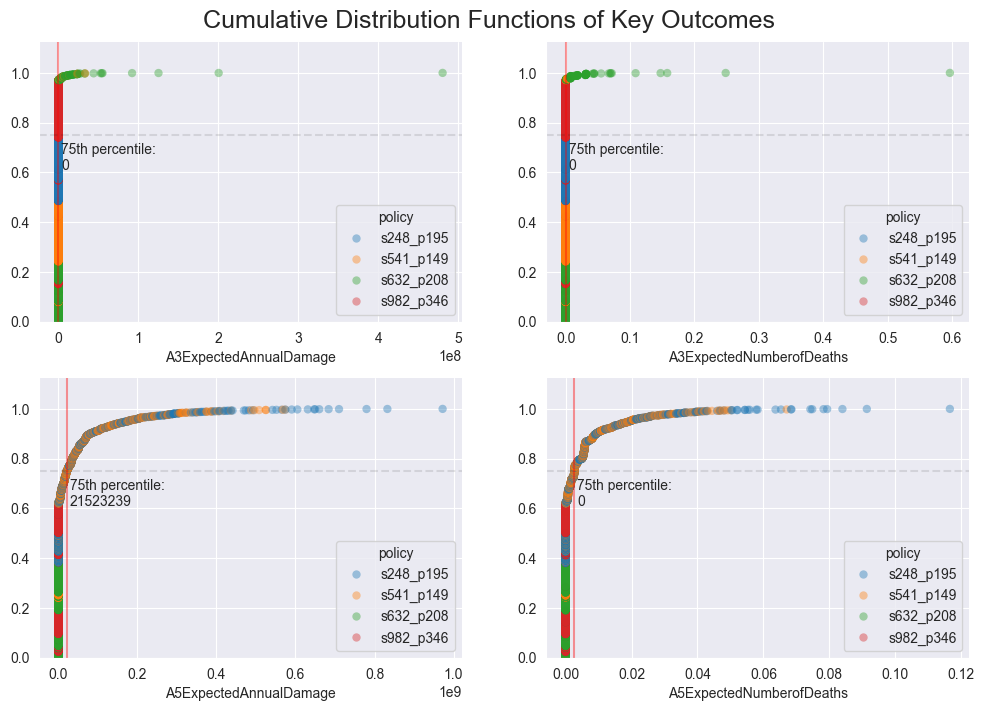

In [12]:
N = experiments.shape[0]
performance_threshold = None

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(outcomes_of_interest, axs.ravel()):
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N)/N
    df = df.reset_index()
    
    # Plot
    sns.scatterplot(data=df, x=col, y='y', hue='policy',
                    legend=True, linewidth=0,
                    alpha=0.4, palette='tab10', ax=ax)

    # Plot line at 75th percentile
    q3 = int(N*0.75)
    ax.axhline(q3/N, color='k', alpha=0.1, ls='--')
    ax.axvline(df[col][q3], label=str(df[col][q3]),
               color='r', alpha=0.4)
    
    # Label line with 75th percentile value
    annotation_point = int(N*0.61)/N # tested to line up with a gridline
    if col.split('_')[-1] == 'Deaths':
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.5f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.0f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    
    # Save performance threshold (75th percentile of outcome of interest)
    if (col == ooi):
        performance_threshold = df[col][q3]

    # Set up graph
    sns.despine(ax=ax)
    col_name = ' '.join(col.split('_'))
    ax.set(xlabel=col_name, ylabel=None, ylim=[0, 1.125])

plt.suptitle(f'Cumulative Distribution Functions of Key Outcomes',
             fontsize=18, y=0.92)
plt.savefig(f'img/vulnerability__CDFs.png')
plt.show()

From these graphs we can see that, under the already-dangerous scenarios being studied here, one of the policies (s248_p195) tends to have a much longer tail and produce higher damages than the other policies. This could indicate that this policy is signficantly more vulnerable to extremes in the uncertainty space than others the others.

We can also see that the 75th percentile value of Expected Number of Deatshs and Expected Annual Damage in Dike Ring 3 and Dike Ring 5 is 0. This means that these four policies keep damage in urban area to 0 in at least 75% of scenarios. Combining this with the visual recognition that one policy tends to be worse than the others, this percentage is could be higher for the other three policies (though the stark difference is less notable in urban areas).

This allows an interesting analysis: when we move to our PRIM algorithm in the next step, we will be searching for a space that defines all scenarios where, even under the strong policies we have discovered and are presenting, there are _still_ damages expected in Dike Ring 3 and 5. This is truly a subspace of great concern to us.

-----------------------------------

## 2. Scenario Discovery -- Subspace Discovery with PRIM

We can run PRIM as we did in `Scenario Discovery.ipynb`, with our binary threshold based off of seeing _any_ damages in Dike Ring 4. The resultant box will define a subspace of concern for the Client even _if_ they adopt our policy.

In [13]:
outcomes

{'A3ExpectedAnnualDamage': array([0., 0., 0., ..., 0., 0., 0.]),
 'A3ExpectedNumberofDeaths': array([0., 0., 0., ..., 0., 0., 0.]),
 'A3DikeInvestmentCosts': array([1.13369259e+10, 1.13369259e+10, 1.13369259e+10, ...,
        3.13565990e+09, 3.13565990e+09, 3.13565990e+09]),
 'A5ExpectedAnnualDamage': array([1.83549292e+08, 0.00000000e+00, 3.99111185e+07, ...,
        1.55240368e+08, 1.90113412e+07, 5.15393804e+07]),
 'A5ExpectedNumberofDeaths': array([0.0199835 , 0.        , 0.00535303, ..., 0.01613748, 0.00306465,
        0.00551858]),
 'A5DikeInvestmentCosts': array([2.03185648e+08, 2.03185648e+08, 2.03185648e+08, ...,
        1.16315003e+09, 1.16315003e+09, 1.16315003e+09]),
 'Total_Dike_Investment': array([2.13964586e+10, 2.13964586e+10, 2.13964586e+10, ...,
        4.42235579e+10, 4.42235579e+10, 4.42235579e+10]),
 'Total_Expected_Annual_Damage': array([1.85993638e+08, 9.50464572e+07, 3.99988159e+07, ...,
        1.55240368e+08, 2.55366574e+07, 5.15393804e+07]),
 'Total_Expected_

In [14]:
uncertainties = ['A0_ID_flood_wave_shape', 'A1_Bmax', 'A1_Brate', 'A1_pfail', 'A2_Bmax',
                 'A2_Brate', 'A2_pfail', 'A3_Bmax', 'A3_Brate', 'A3_pfail', 'A4_Bmax',
                 'A4_Brate', 'A4_pfail', 'A5_Bmax', 'A5_Brate', 'A5_pfail',
                 'discount_rate_0', 'discount_rate_1', 'discount_rate_2',]

In [15]:
# drop the levers and unnecessary columns to analyse the coverage
# drop the levers
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)
# drop the unnecessary attribute
cleaned_experiments.drop(columns= ['scenario', 'policy', 'model'], inplace= True)
# show the dataframe
cleaned_experiments

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                          89  310.175405       1.5   0.380051  309.965098   
1                         120  276.331031       1.0   0.688478  265.427152   
2                           1  279.963545       1.5   0.632931  220.499141   
3                           3  117.684721      10.0   0.192252  271.550946   
4                          61  288.041336      10.0   0.074401   70.571871   
...                       ...         ...       ...        ...         ...   
3995                       72  211.546263       1.5   0.559319  215.780097   
3996                      105  227.169716       1.0   0.828171  161.176093   
3997                       95  154.222915       1.5   0.909816  180.681616   
3998                       98  308.305372      10.0   0.462406  184.998086   
3999                       54  166.438255      10.0   0.778801  103.853193   

     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail    A.4_Bmax  \
0          1.5   0.298979  157.098288       1.5   0.762968  230.651297   
1          1.5   0.487053  305.543549      10.0   0.843199  130.515764   
2         10.0   0.460423  165.727175       1.5   0.792592  140.163421   
3          1.5   0.292257  229.755801      10.0   0.226455   85.126679   
4          1.5   0.695022  272.350835       1.0   0.043867  114.384476   
...        ...        ...         ...       ...        ...         ...   
3995       1.5   0.362357  264.267436       1.0   0.396460  105.314336   
3996       1.0   0.028896  155.231153      10.0   0.766054  237.360804   
3997       1.5   0.282187  285.140286       1.0   0.764284  174.147168   
3998      10.0   0.354839  334.687412       1.0   0.703266  132.097125   
3999       1.0   0.713983  287.452833      10.0   0.238387  255.616386   

     A.4_Brate  A.4_pfail    A.5_Bmax A.5_Brate  A.5_pfail discount rate 0  \
0         10.0   0.706592   76.751161       1.5   0.151445             2.5   
1          1.0   0.045688  134.866777      10.0   0.934202             1.5   
2          1.0   0.879200  186.591740       1.5   0.365036             3.5   
3          1.0   0.112688  290.869844       1.5   0.419024             4.5   
4          1.5   0.238691  263.756138       1.5   0.116658             3.5   
...        ...        ...         ...       ...        ...             ...   
3995       1.0   0.981904   45.733118       1.0   0.133356             3.5   
3996      10.0   0.043551   57.758143       1.5   0.218552             4.5   
3997      10.0   0.639558  167.633183       1.5   0.089137             2.5   
3998      10.0   0.097522  240.671461       1.0   0.307277             4.5   
3999       1.5   0.787945  210.909259      10.0   0.434758             2.5   

     discount rate 1 discount rate 2  
0                3.5             2.5  
1                3.5             1.5  
2                1.5             2.5  
3                3.5             4.5  
4                1.5             3.5  
...              ...             ...  
3995             4.5             3.5  
3996             1.5             2.5  
3997             3.5             1.5  
3998             4.5             2.5  
3999             1.5             4.5  

[4000 rows x 19 columns]

In [16]:
x = cleaned_experiments
y = outcomes['Total_Expected_Number_of_Deaths'] > np.percentile (outcomes['Total_Expected_Number_of_Deaths'], 50)
prim_alg = prim.Prim(x, y, threshold=0.8)
box2 = prim_alg.find_box()

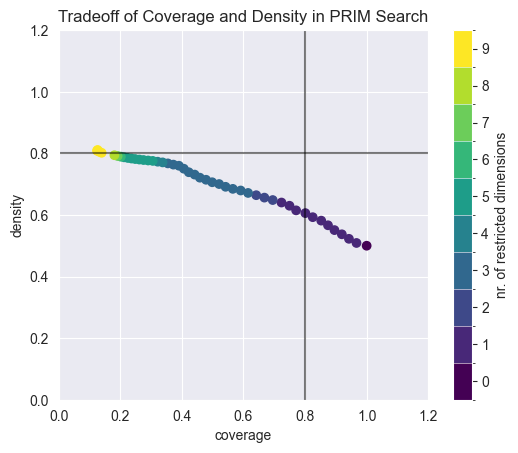

In [17]:
box2.show_tradeoff()

plt.hlines(y=[0.80], xmin=0, xmax=1.2, colors='k', alpha=0.5)
plt.vlines(x=[0.80], ymin=0, ymax=1.2, colors='k', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search')
plt.savefig('img/vulnerability__prim_trajectory.png')
plt.show()

In [18]:
candidates = box2.peeling_trajectory
candidates = candidates[candidates.density
                      == candidates.density.max()]
candidates

coverage   density  id    k   mass      mean    n  res_dim
45    0.1265  0.810897  45  253  0.078  0.810897  312        9

This time, we will choose the option with higher coverage. Since all these scenarios are concerning in some way, we are less worried about "false positives." Even unmarked scenarios included in the PRIM box might still be of concern. Our focus is on capturing as many marked scenarios as possible.

In [19]:
# Select the best candidate box with the highest density from the peeling trajectory
best_box_idx = int(candidates.index[0])

box2.select(best_box_idx)
best_box_idx

45

This bounding box only restricts in one dimension. 

In [20]:
# Set the style of the seaborn plots to 'whitegrid' for better visibility of the grid lines
sns.set_style('whitegrid')

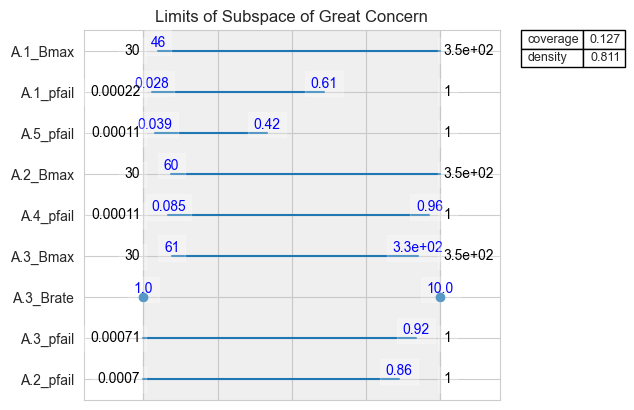

In [21]:
# Inspect the selected PRIM box by visualizing the limits of the subspace of great concern
box2.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Limits of Subspace of Great Concern')
plt.savefig('img/vulnerability__prim_boundary.png')
plt.show()

The plot visualizes the limits of the subspace of great concern identified by the PRIM algorithm for the IJssel River Room for the River project. Each row represents an uncertainty factor (e.g., A1_Bmax, A1_pfail) along with its value range within the identified subspace. The blue numbers indicate the boundary values of these uncertainties, highlighting the range within which the scenarios are of greatest concern. The coverage, displayed in the top right corner, is 12.7%, indicating the proportion of total scenarios falling within this subspace. The density, at 81.1%, reflects the concentration of high-risk scenarios within these boundaries. This visualization helps in understanding which uncertainty factors and their specific ranges contribute most significantly to scenarios of great concern, aiding in targeted policy interventions.

In [22]:
sns.set_style('white')

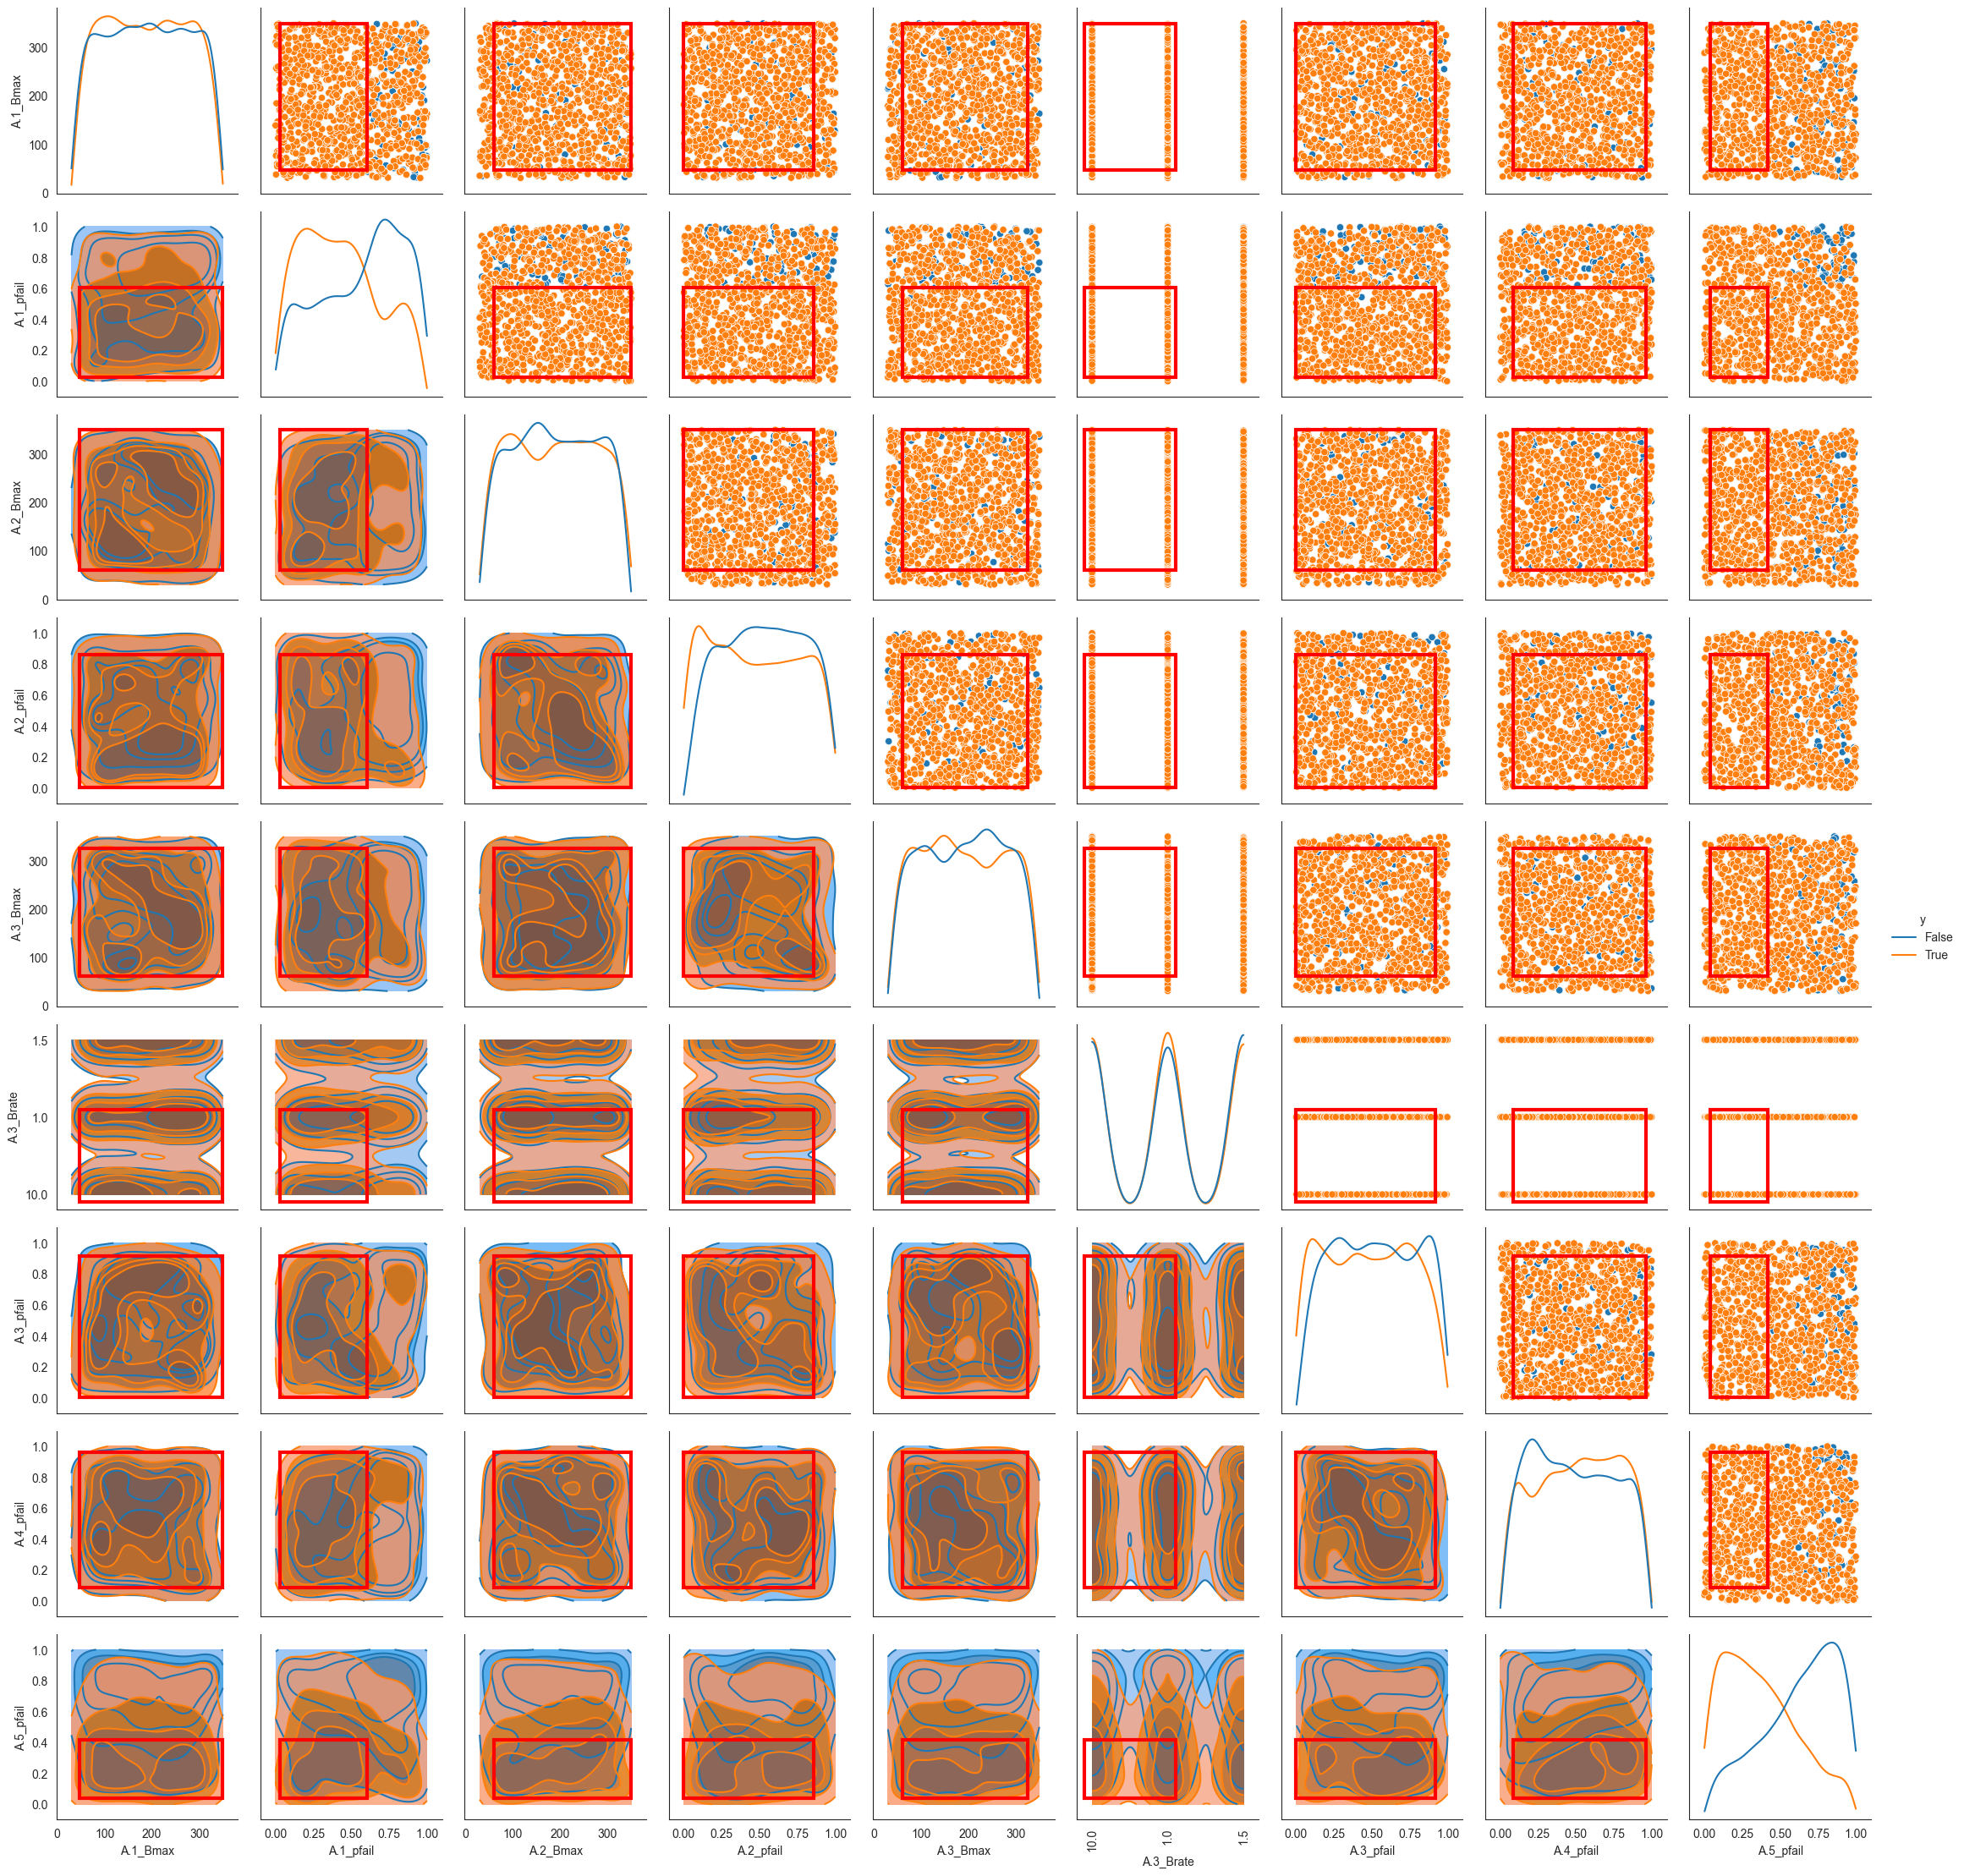

In [30]:
box2.show_pairs_scatter()
plt.savefig('./img/vulnerability__prim_pairs_scatter.png')
plt.show()



This KDE shows the stark limitations of the cases we marked as scenarios of concern in this final process, and how densely they are located at low `A3_pfail` and `A5_pfail`. 

--------------------------

## 3. Filter, Sort, and Save Outputs

For completeness and to provide the Client with full information, we will filter the set of scenarios that fall within this new subspace of great concern. These scenarios can be used for worst-case modelling in the future, especially if one of the proposed policies is adopted.

In [25]:
# Extracting the limits of the selected PRIM box to understand the boundaries of the subspace of concern.
limits = box2.box_lims[best_box_idx]
#limits

# Create a new dataframe of experiments & their outcomes
# and track whether they fall outside the PRIM box boundary
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]

combined_df['Within Limit'] = True

print(combined_df.shape)
combined_df.head(3)

(4000, 63)


A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                       89  310.175405       1.5   0.380051  309.965098   
1                      120  276.331031       1.0   0.688478  265.427152   
2                        1  279.963545       1.5   0.632931  220.499141   

  A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0       1.5   0.298979  157.098288       1.5   0.762968  ...   
1       1.5   0.487053  305.543549      10.0   0.843199  ...   
2      10.0   0.460423  165.727175       1.5   0.792592  ...   

   A3ExpectedAnnualDamage A3ExpectedNumberofDeaths  A3DikeInvestmentCosts  \
0                     0.0                      0.0           1.133693e+10   
1                     0.0                      0.0           1.133693e+10   
2                     0.0                      0.0           1.133693e+10   

   A5ExpectedAnnualDamage A5ExpectedNumberofDeaths  A5DikeInvestmentCosts  \
0            1.835493e+08                 0.019983           2.031856e+08   
1            0.000000e+00                 0.000000           2.031856e+08   
2            3.991112e+07                 0.005353           2.031856e+08   

  Total_Dike_Investment Total_Expected_Annual_Damage  \
0          2.139646e+10                 1.859936e+08   
1          2.139646e+10                 9.504646e+07   
2          2.139646e+10                 3.999882e+07   

  Total_Expected_Number_of_Deaths  Within Limit  
0                        0.020162          True  
1                        0.004561          True  
2                        0.005361          True  

[3 rows x 63 columns]

In [26]:
# Apply PRIM constraint in each dimension
for idx, row in combined_df.iterrows():
    for unc in limits:
        if (type(limits.loc[0, unc]) == set):
            if row[unc] not in limits.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limits.loc[0, unc] or row[unc] > limits.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [27]:
# Use new column to filter the rows, then drop this column
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
print(f'{combined_df.shape[0]} scenarios remain in the PRIM box.')

312 scenarios remain in the PRIM box.


We have filtered down to 4000 scenarios. This makes sense, as it is roughly 10% of the set we started with (the scenarios that produced any damage to A3 and A5 under the status quo). 4000 scenarios is quite a few, so the next step will be to select a diverse, representative set of 3-5 of these scenarios that we can carry forward and use in our policy search. The generation of candidate sets and the assessment of set diversity will be done in [3.b. scenario_diversity_evaluation.py](3.b.%20scenario_diversity_evaluation.py). To support this set generation and filtering, we will save the filtered, combined experiments and outcomes DataFrame in sorted order by outcome 'A3 Expected Annual Damage', 'A3 Expected Annual Deaths', 'A5 Expected Annual Damage', and 'A5 Expected Annual Deaths'.

In [28]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head(3)

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
2135                      125   68.148224       1.5   0.505925  147.949761   
3135                      125   68.148224       1.5   0.505925  147.949761   
2536                       78  310.565204       1.5   0.592235   73.809977   

     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...     model  \
2135       1.5   0.324639  152.406709       1.0   0.000709  ...  dikesnet   
3135       1.5   0.324639  152.406709       1.0   0.000709  ...  dikesnet   
2536       1.5   0.836525  136.260856       1.0   0.016219  ...  dikesnet   

     A3ExpectedAnnualDamage  A3ExpectedNumberofDeaths  A3DikeInvestmentCosts  \
2135           4.803610e+08                  0.596306           5.899750e+08   
3135           3.350148e+07                  0.005332           3.135660e+09   
2536           2.374189e+07                  0.031534           5.899750e+08   

     A5ExpectedAnnualDamage  A5ExpectedNumberofDeaths A5DikeInvestmentCosts  \
2135           0.000000e+00                  0.000000          4.683455e+09   
3135           1.745243e+08                  0.014091          1.163150e+09   
2536           0.000000e+00                  0.000000          4.683455e+09   

     Total_Dike_Investment Total_Expected_Annual_Damage  \
2135          9.967628e+09                 4.803610e+08   
3135          4.422356e+10                 2.080257e+08   
2536          9.967628e+09                 2.374189e+07   

      Total_Expected_Number_of_Deaths  
2135                         0.596306  
3135                         0.019423  
2536                         0.031534  

[3 rows x 62 columns]

In [29]:
output_filename = input_filename + '__prim_filtered.csv'
combined_df.to_csv(output_filename, index=True)